In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))
# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 2.7 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15359, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 15359 (delta 31), reused 37 (delta 14), pack-reused 15275
Receiving objects: 100% (15359/15359), 6.23 MiB | 18.50 MiB/s, done.
Resolving deltas: 100% (11146/11146), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.0 MB/s eta 0:00:00
  

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.1 ; cuda:  cu121
detectron2: 0.6


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from matplotlib import pyplot as plt

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("dataset_train2", {}, "/content/drive/MyDrive/Dataset/COCO_output/train/coco_annotations.json", "/content/drive/MyDrive/Dataset/COCO_output/train")
register_coco_instances("dataset_val2", {}, "/content/drive/MyDrive/Dataset/COCO_output/val/coco_annotations.json", "/content/drive/MyDrive/Dataset/COCO_output/val")

In [ ]:
train_metadata = MetadataCatalog.get("dataset_train2")
train_dataset_dicts = DatasetCatalog.get("dataset_train2")
val_metadata = MetadataCatalog.get("dataset_val2")
val_dataset_dicts = DatasetCatalog.get("dataset_val2")

[02/08 15:12:35 d2.data.datasets.coco]: Loading /content/drive/MyDrive/Dataset/COCO_output/train/coco_annotations.json takes 4.52 seconds.
[02/08 15:12:35 d2.data.datasets.coco]: Loaded 532 images in COCO format from /content/drive/MyDrive/Dataset/COCO_output/train/coco_annotations.json
[02/08 15:12:36 d2.data.datasets.coco]: Loaded 133 images in COCO format from /content/drive/MyDrive/Dataset/COCO_output/val/coco_annotations.json


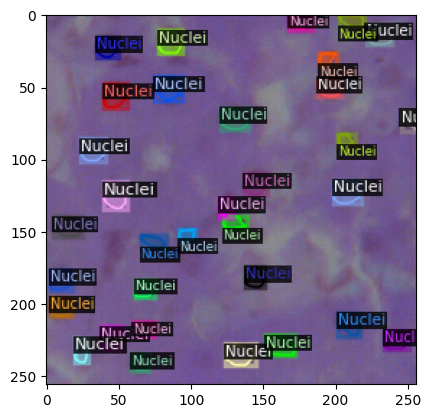

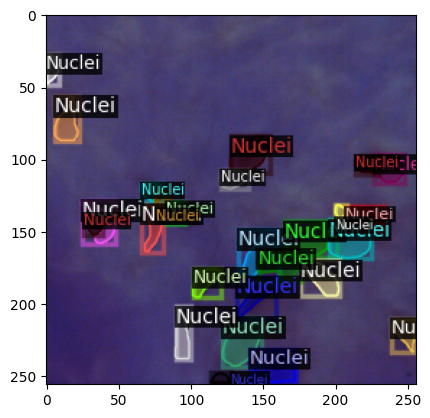

In [ ]:
# Visualize some random samples
for d in random.sample(train_dataset_dicts, 2):
  img = cv2.imread(d["file_name"])
  visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
  vis = visualizer.draw_dataset_dict(d)
  plt.imshow(vis.get_image()[:, :, ::-1])
  plt.show()


In [ ]:
from detectron2.engine import DefaultTrainer
cfg = get_cfg()
cfg.OUTPUT_DIR = "/content/drive/MyDrive/Dataset/models/Detectron2_Models"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("dataset_train2",)
cfg.DATASETS.TEST = ()
cfg.DATASETS.VAL = ("dataset_val2",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml") # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2 # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025 # pick a good LR
cfg.SOLVER.MAX_ITER = 10000
cfg.SOLVER.STEPS = [] # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256 # Default is 512, using 256 for this dataset.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 # We have 1 classes. (Nuclei)
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
trainer.resume_or_load(resume=False)
#Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available

[02/08 15:13:37 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:01, 158MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


In [ ]:
trainer.train() #start the training process

[02/08 15:13:51 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[02/08 15:14:04 d2.utils.events]:  eta: 1:05:00  iter: 19  total_loss: 6.307  loss_cls: 0.6435  loss_box_reg: 0.4825  loss_mask: 0.6924  loss_rpn_cls: 4.122  loss_rpn_loc: 0.2661    time: 0.3915  last_time: 0.4041  data_time: 0.0763  last_data_time: 0.0665   lr: 4.9953e-06  max_mem: 2078M
[02/08 15:14:16 d2.utils.events]:  eta: 1:04:21  iter: 39  total_loss: 4.186  loss_cls: 0.5995  loss_box_reg: 0.6159  loss_mask: 0.6881  loss_rpn_cls: 2.072  loss_rpn_loc: 0.2522    time: 0.3876  last_time: 0.3841  data_time: 0.0107  last_data_time: 0.0093   lr: 9.9902e-06  max_mem: 2078M
[02/08 15:14:24 d2.utils.events]:  eta: 1:04:45  iter: 59  total_loss: 2.643  loss_cls: 0.5741  loss_box_reg: 0.6251  loss_mask: 0.6788  loss_rpn_cls: 0.5162  loss_rpn_loc: 0.2256    time: 0.3936  last_time: 0.4238  data_time: 0.0109  last_data_time: 0.0060   lr: 1.4985e-05  max_mem: 2499M
[02/08 15:14:32 d2.utils.events]:  eta: 1:05:08  iter: 79  total_loss: 2.459  loss_cls: 0.5443  loss_box_reg: 0.7001  loss_mask: 

In [ ]:
os.rename(os.path.join(cfg.OUTPUT_DIR, "model_final.pth"), os.path.join(cfg.OUTPUT_DIR, "model_10k_iter.pth"))

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_10k_iter.pth") # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2 # set a custom threshold 4
predictor = DefaultPredictor(cfg)

[02/08 16:26:37 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/Dataset/models/Detectron2_Models/model_10k_iter.pth ...


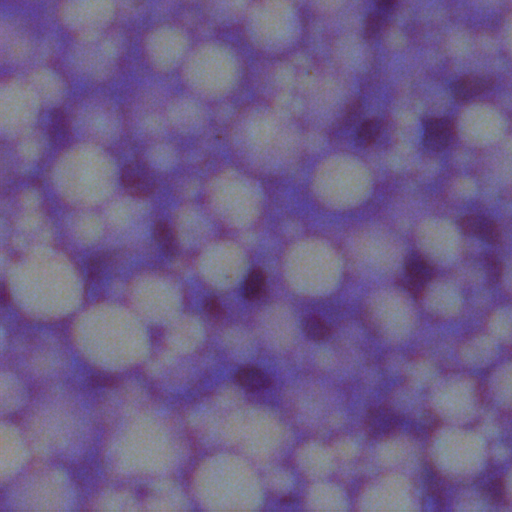

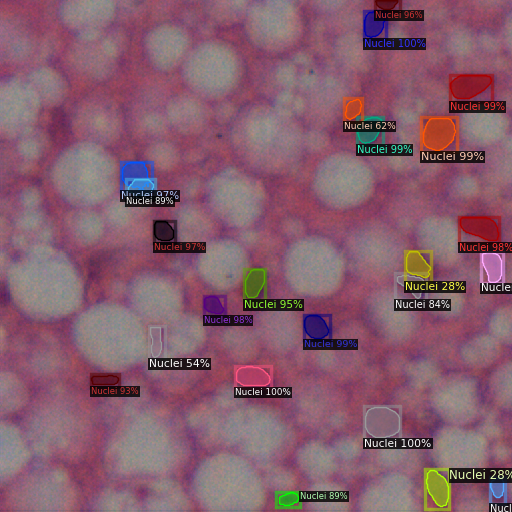

In [ ]:
new_im = cv2.imread("/content/drive/MyDrive/Dataset/COCO_output/test/mouse_subscapula_07.png")
outputs = predictor(new_im)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(new_im[:, :, ::-1])
cv2_imshow(out.get_image()[:, :, ::-1])